In [22]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from random import randint
#  from scipy.stats import bernoulli
import ipynb
from ipynb.fs.full.two_coin_v1 import sim_two_coin

In [23]:
def displayChart(tab):
    Chart=[]
    columns = []
    N = len(tab)-1
    for i in range(N, -1, -1):
        chart = []
        columns.append(N-i)
        for j in range(0,i):
            chart.append("")
        for j in range(i, N+1):
            entry = tab[j][i]
            chart.append(entry)
        Chart.append(chart)
    df = pd.DataFrame(Chart, columns = columns)
    return df.style.hide_index()

In [24]:
# parameters
S0=30
r=0.04
t=6
rate_drift = 0
rate_volatility = 0.002
drift = 0 # drift for stock price
u=1+r+math.sqrt((1+r)**2-1) 
d=(1+r)/u
face=50
coupon_rate = 0.04
coupon = coupon_rate*face
default_threshold = 1/3
bankrupcy_ratio = 2.4
K=55 # call at this value
Pu=50 # put at this value

def simulate_single(x):

    vol=x # volatility for stock price: for additive amount, how much to add
    
    def g(x): # payoff function e.g for a call it would be max(0, x-K)
        if x==0:
            return [0, 0]
        if x <= default_threshold*S0:
            return [x*bankrupcy_ratio, 0]
        return [face, coupon] # first entry is the actual value, second is dividends or coupons
    
    # p=0.5#(1+r-d)/(u-d)
    # q=1-p
    # p=1-q # fixes floating-point errors hopefully
    # print(p, q) # only use these in the multiplicative model
    
    def nSigFigs(num, n):
        #print(num == np.nan)
        if type(num) not in [float, int, np.float64] or num == float("NaN"): return float("NaN")
        return int(num * 10**n) / 10**n
    
    def r_values(drift, vol):
        R = {}
        for i in range(t, -1, -1):
            R[i] = r + i*drift - vol*np.arange(i, -1, -1) + vol*np.arange(0, i+1, 1)
        return R

    interests = r_values(rate_drift, rate_volatility)
    # print("interest rates")
    # displayChart(rates)

    rates = {}
    for key in range(0, t+1, 1):
        rates[key] = [0]*(key+1)
        for j in range(0, key+1, 1):
            index = randint(0, key)
            rates[key][j] = interests[key][index]

    
    def StockPrice(mode='a'): # a for additive, m for multiplicative
        StockPrice={}
        if mode == 'm':
            for i in range(t, -1, -1):
                StockPrice[i] = S0 * d ** (np.arange(i,-1,-1)) * u ** (np.arange(0,i+1,1)) #np.empty(N+1)

        elif mode == 'a':
            for i in range(t, -1, -1):
                StockPrice[i] = np.maximum(np.zeros(i+1), S0 + i*drift - vol*np.arange(i, -1, -1) + vol*np.arange(0,i+1,1))
        '''for n in range(0, N+1):
            StockPrice[N].append(S0*(u**n)*(d**(N-n)))
        for i in range(N-1, -1, -1):
            StockPrice[i]=[] #np.empty(i+1)
            for j in range(0, i+1):
                StockPrice[i].append((StockPrice[i+1][j+1])/u)'''
        return StockPrice

    SP = StockPrice()
    # print("stock price")
    # displayChart(SP)
    
    def p_values(stock_price_chart, rates):
        P = {i: [1]*(i+1) for i in range(t+1)}
        for i in range(0, t):
            for j in range(i+1):
                if stock_price_chart[i][j] == 0:
                    P[i][j] = -1
                else:
                    d = stock_price_chart[i+1][j] / stock_price_chart[i][j]
                    u = stock_price_chart[i+1][j+1] / stock_price_chart[i][j]
                    P[i][j] = (1 + rates[i][j] - d) / (u-d)
                    # print(d)
                    # print(u)
                    # print(u-d)
                    # print(1+rates[i][j])
                    # print(1 + rates[i][j] - d)
        return P

    p_vals = p_values(SP, rates)
    # print("p tilde")
    # displayChart(p_vals)
    
    # expected stock price (risk neutral pricing)
    # additive model
    def exp(x,y,p,r):
        if p != -1:
            return (x*p+y*(1-p))/(1+r)
        return 0

    # # multiplicative model
    # def rnExp(x,y, p=p,r=r):
    #     return exp(x,y,p,r)
    
        
    bond_payoff = list(map(g, SP[t]))
    def vanillaBond(payoff): # coupon amount
        vanillaBond={}
        vanillaBond[t]=payoff
        #IP=IntrinsicPut()
        #for n in range(0, N+1):
        #    PutPriceA[N].append(IP[N][n])
        for i in range(t-1, -1, -1):
            vanillaBond[i]=[]
            for j in range(i+1):
                entry = [0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(vanillaBond[i+1][j+1][0], vanillaBond[i+1][j][0], p_vals[i][j], rates[i][j]) + exp(vanillaBond[i+1][j+1][1], vanillaBond[i+1][j][1], p_vals[i][j], rates[i][j])
                    entry[1] = coupon if (SP[i][j] >= default_threshold) and i>0 else 0
                #print(entry)
                vanillaBond[i].append(entry)
        return vanillaBond

    vBond = vanillaBond(bond_payoff)
    # print("Vanilla Bond payoff: [face value (after coupon), coupon]")
    # displayChart(vBond)

    def convBond(payoff):
        convBond = {}
        convBond[t] = [[max(SP[t][i], payoff[i][0]), payoff[i][1]] for i in range(t+1)]
        for i in range(t-1, -1, -1):
            convBond[i]=[]
            for j in range(i+1):
                entry = [0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(convBond[i+1][j+1][0], convBond[i+1][j][0], p_vals[i][j], rates[i][j]) \
                            + exp(convBond[i+1][j+1][1], convBond[i+1][j][1], p_vals[i][j], rates[i][j])
                    entry[0] = max(entry[0], SP[i][j])
                    entry[1] = coupon if SP[i][j] >= default_threshold else 0
                #print(entry)
                convBond[i].append(entry)
        convBond[0][0][1]=0
        return convBond

    cBond = convBond(bond_payoff)
    # print("Convertible Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible but not callable")
    # displayChart(cBond)

    def callable2(convertible): # convertible and callable, conversion prioritized
        callBond = {}
        callBond[t] = [[min(K, convertible[t][i][0]), convertible[t][i][1],0] for i in range(t+1)]
        for i in range(t+1):
            # 0 means not called, 1 means called
            callBond[t][i][2] = 1 if (K<=convertible[t][i][0]) else 0
        for i in range(t-1, -1, -1):
            callBond[i]=[]
            for j in range(i+1):
                entry = [0,0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(callBond[i+1][j+1][0], callBond[i+1][j][0], p_vals[i][j], rates[i][j])
                    entry[0] += exp(callBond[i+1][j+1][1], callBond[i+1][j][1], p_vals[i][j], rates[i][j])
                    entry[2] = 1 if (K<entry[0]) else 0
                    entry[0] = entry[0] = min(max(K, SP[i][j]), entry[0])
                    entry[1] = coupon if ((SP[i][j] >= default_threshold) and i>0) else 0
                #print(entry)
                callBond[i].append(entry)
        return callBond

    callable_bond = callable2(cBond)
    # print("Callable Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible and callable")
    # print("Call after convertion")
    # displayChart(callable_bond)
    
    def putable(convertible):
        putBond = {}
        putBond[t] = [[convertible[t][i][0], convertible[t][i][1],0] for i in range(t+1)]
        for i in range(t+1):
            # 0 means not called, 1 means called
            putBond[t][i][2] = 1 if (K>=convertible[t][i][0]) else 0
        for i in range(t-1, -1, -1):
            putBond[i]=[]
            for j in range(i+1):
                entry = [0,0,0]
                if SP[i][j] != 0: 
                    entry[0] = exp(putBond[i+1][j+1][0], putBond[i+1][j][0], p_vals[i][j], rates[i][j])
                    entry[0] += exp(putBond[i+1][j+1][1], putBond[i+1][j][1], p_vals[i][j], rates[i][j])
                    if(SP[i][j]==0):
                        # bankrupt
                        entry[0] = 0
                        entry[1] = 0
                        entry[2] = 0
                    elif(0<SP[i][j]<=default_threshold):  
                        # financial distress
                        entry[0] = max(Pu/2, entry[0])
                        entry[1] = 1 if ((Pu/2)>entry[0]) else 0
                        entry[2] = 0 
                    else:       
                        entry[0] = max(Pu, entry[0]) if (i<t) else entry[0]
                        entry[2] = 1 if (Pu>entry[0]) else 0
                        entry[1] = coupon if (i>0) else 0
                #print(entry)
                putBond[i].append(entry)
        return putBond

    put_bond = putable(cBond)
    # print("Putabl Bond payoff: [face value (after coupon), coupon]")
    # print("Convertible and putable")
    # displayChart(put_bond)

    put_bond = putable(cBond)
    put_price = put_bond[0][0]

    callable_bond = callable2(cBond)
    min_price = callable_bond[0][0]
    
    v_val = vBond[0][0]
    c_val = cBond[0][0]

    return [v_val[0], c_val[0], min_price[0], put_price[0]]

print("vanilla defaultable, basic convertible, convertible and callable, convertible and putable")
# displayChart(simulate_single(5))
simulate_single(5)

vanilla defaultable, basic convertible, convertible and callable, convertible and putable


[48.73296295028683, 49.48970514064758, 49.11133404546721, 50.83061202711939]

In [25]:
runs = 5 # number of simulations at each vol (how much to increase/decrease in the additive model)
lo = 3 # lowest vol
hi = 13 # highest vol
incr = -0.1 # negative

keys = np.arange(hi, lo, incr)
v_price = {}
c_price = {}
callable_price = {}
putable_price = {}
two_coin = {}

for i in keys: # try different vol 
    v_price[i] = ([0]*runs)
    c_price[i] = ([0]*runs)
    callable_price[i] = ([0]*runs)
    putable_price[i] = ([0]*runs)
    two_coin[i] = [sim_two_coin(t, i, r, rate_volatility)]
    for j in range(0, runs, 1): 
        (v_price[i][j], c_price[i][j], callable_price[i][j], putable_price[i][j]) = simulate_single(i)

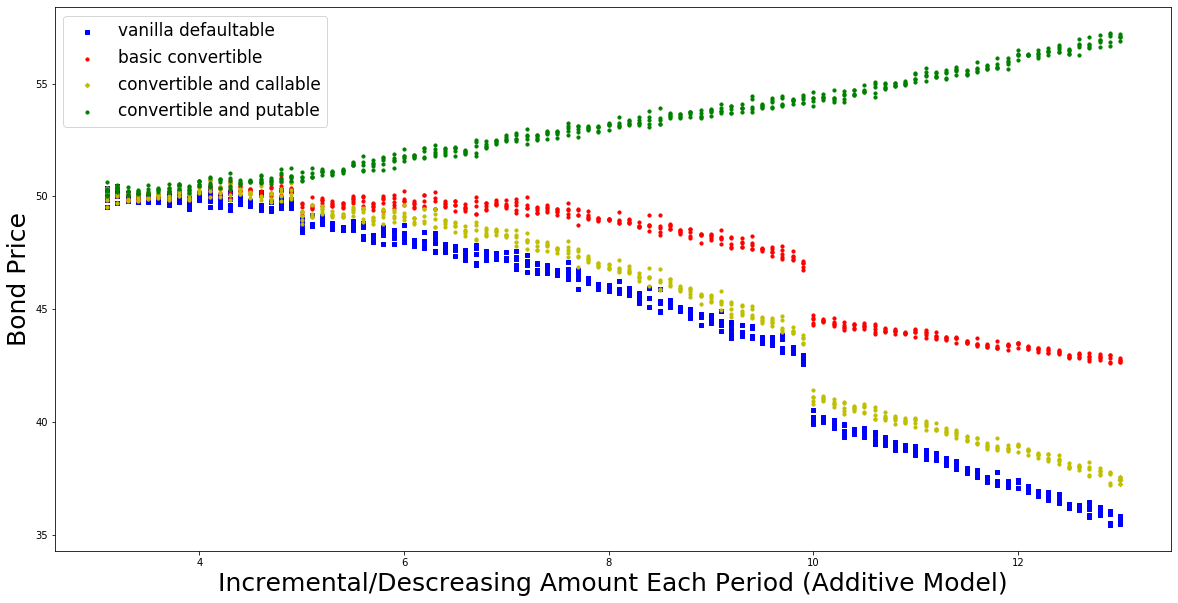

In [26]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot()
plt.xlabel('Incremental/Descreasing Amount Each Period (Additive Model)', fontsize = 25) 
plt.ylabel('Bond Price', fontsize = 25)               

for key in v_price:
    if(key == lo or key == hi):
        ax1.scatter([key]*runs, v_price[key], s=10, c='b', marker="s", label="vanilla defaultable")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o", label="basic convertible")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y', marker="D", label="convertible and callable")
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o", label="convertible and putable")
    else:
        ax1.scatter([key]*runs, v_price[key], s=10, c='b', marker="s")
        ax1.scatter([key]*runs, c_price[key], s=10, c='r', marker="o")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='y')
        ax1.scatter([key]*runs, putable_price[key], s=10, c='g', marker="o")

plt.legend(loc='upper left', fontsize = 17)
plt.show() 

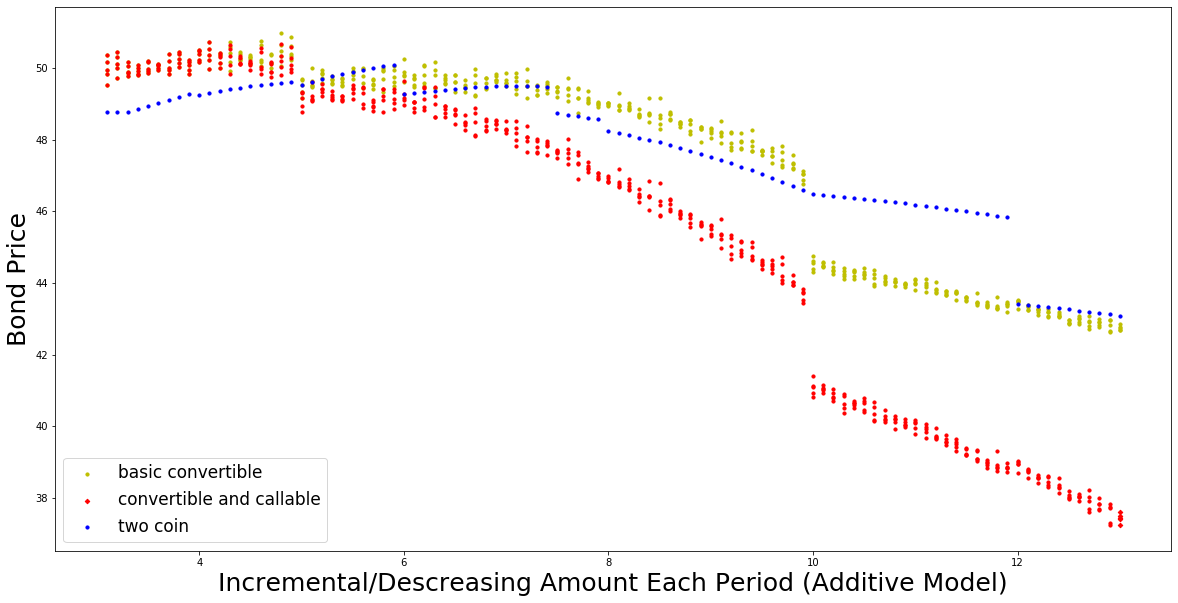

In [27]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot()
plt.xlabel('Incremental/Descreasing Amount Each Period (Additive Model)', fontsize = 25) 
plt.ylabel('Bond Price', fontsize = 25)               

for key in v_price:
    if(key == lo or key == hi):
        ax1.scatter([key]*runs, c_price[key], s=10, c='y', marker="o", label="basic convertible")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='r', marker="D", label="convertible and callable")
        ax1.scatter([key], two_coin[key], s=10, c='b', marker="o", label="two coin")
        
    else:
        ax1.scatter([key]*runs, c_price[key], s=10, c='y', marker="o")
        ax1.scatter([key]*runs, callable_price[key], s=10, c='r')
        ax1.scatter([key], two_coin[key], s=10, c='b', marker="o")

plt.legend(loc='lower left', fontsize = 17)
plt.show() 